1. The code snippet in Listing 1 shows the code to generate a noisy point set X amounting to a circle and the
code to estimate a circle—center and the radius—from a set of inliers in X.


In [1]:
import numpy as np
from scipy import optimize
from scipy import linalg
import matplotlib.pyplot as plt
import random
import cv2 as cv

In [5]:
def model_circle(point_list):
    """
    Returns the center and radius of the circle passing the given 3 points.
    """
    p1,p2,p3 = point_list[0], point_list[1], point_list[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    """
    Returns the list of inliers to a model of a circle from a set of points.
    The threshold value is taken as 1/5th of the radius
    """
    inliers = []
    thresh = r//5

    for i in range(len(data_list)):
        error = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2) - r
        if error < thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

def random_sample(data_list):
    """
    Returns a list of 3 random samples from a given list
    """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def calc_R(x_, y_, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x_-xc)**2 + (y_-yc)**2)

def f_2(c, x_, y_):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x_, y_, *c)
    return Ri - Ri.mean()

def estimateCircle(x_m, y_m, points):
    x_ = points[:,0]
    y_ = points[:,1]
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate, (x_, y_))

    xc_2, yc_2 = center_2

    Ri_2 = calc_R(x_, y_, *center_2)
    R_2 = Ri_2.mean()
    # residu_2   = sum((Ri_2 - R_2)**2)
    return (xc_2, yc_2), R_2

In [6]:
# RANSAC
def RANSAC(data_list, itr):
    """
    Return the center, radius and the best sample and its inliers used to fit the circle to a set of points using RANSAC
    """
    best_sample = []
    best_center_sample = (0,0)
    best_radius_sample = 0
    best_inliers = []
    max_inliers = 0
    
    for i in range(itr):
        samples = random_sample(data_list)  # Generating a random sample of 3 points
        center, radius = model_circle(samples) # Calculting the center and the radius of the circle created by the 3 points
        inliers = get_inliers(data_list, center, radius) # Get the list of inliers
        num_inliers = len(inliers)

        # If a better approximation has been reached
        if num_inliers > max_inliers:
            best_sample = samples
            max_inliers = num_inliers
            best_center_sample = center
            best_radius_sample = radius
            best_inliers = inliers

    print("Center of Sample=", best_center_sample)
    print("Radius of Sample=", best_radius_sample)

    return best_center_sample, best_radius_sample, best_sample, best_inliers

Center = (0.3875662946664744, 0.20783294446043665)
Radius = 9.79406671357652
Ratio of inliers = 84.0 %
Center of RANSAC = (0.11145660376803412, 0.08177822844398985)
Radius of RANSAC = 9.895950353692601


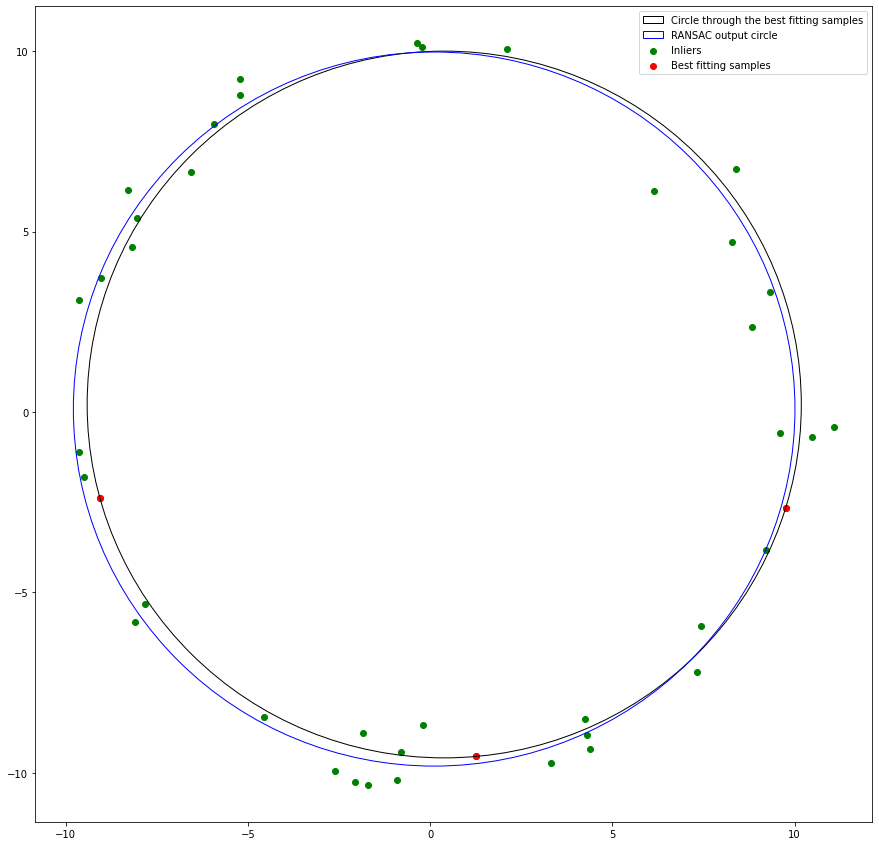

In [21]:
# Generating the set of points that estimate a circle randomly
np.random.seed(6)
N = 100
half_n = N // 2
r = 10
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Calculting the RANSAC outputs for the data set
center, radius, sample, inliers = RANSAC(X_circ, 20000)

# Plotting
fig,ax = plt.subplots(1,1, figsize = (15,15))
# Plotting the circle that is created by the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)

# Plotting the circle
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")
ax.legend()

2. Figure 2 shows an architectural image1 with a flag 2
superimposed. This is done by clicking four points on a
planar surface in the architectural image, computing a homography that maps the flag image to this plane,
and warping the flag, and blending on to the architectural image. Carry this out for a couple of image pairs
of you own choice. You may explain the (non-technical) rationale of your choice

[[ 4.94206448e-01  5.03837806e-03 -4.42644714e+01]
 [-7.32445813e-02  3.48399126e-01 -6.12914633e+01]
 [-5.87244177e-04 -3.91912277e-05  1.00000000e+00]]


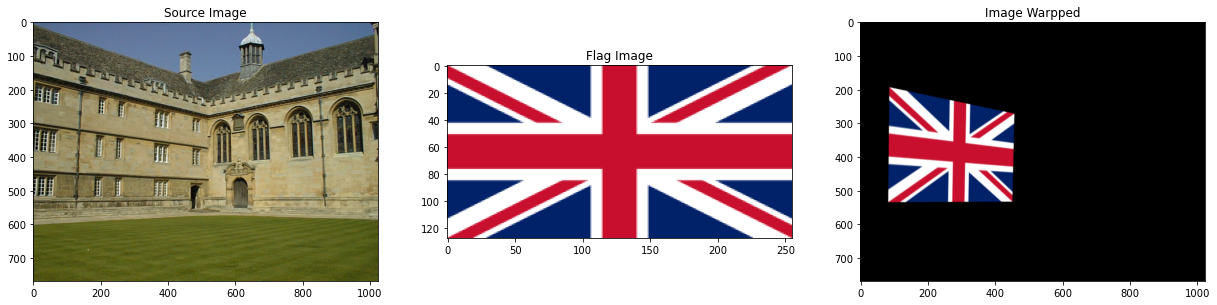

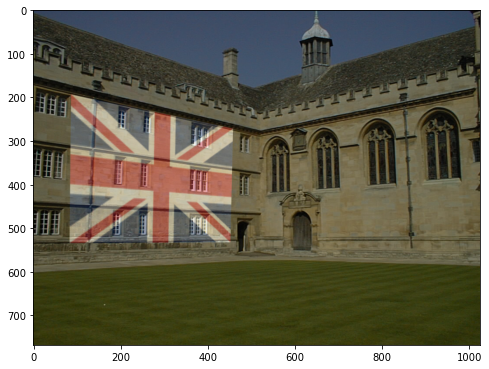

In [19]:
N = 4 # Number of points
global n
n = 0

# Parameters of the two images
p = np.empty((N,2))
p_flag = np.empty((N,2))

# Mouse callback function
def draw_circle(event,x,y,flags,param):
    global n
    p = param[0]
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(param[1],(x,y),5,(255,0,0),-1)
        p[n] = (x,y)
        n += 1

# Importing the images and creating copies
im = cv.imread('images/001.jpg', cv.IMREAD_COLOR)
im_flag = cv.imread('images/Flag_of_the_United_Kingdom.png', cv.IMREAD_COLOR)
im_copy = im.copy()
im_flag_copy = im_flag.copy()

# Getting the mouse points of the base image
cv.namedWindow('Image', cv.WINDOW_AUTOSIZE)
param = [p, im_copy]
cv.setMouseCallback('Image',draw_circle, param)
while(1):
    cv.imshow('Image', im_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break

# Getting the mouse points of the flag
n = 0
cv.namedWindow('Image Flag', cv.WINDOW_AUTOSIZE)
param = [p_flag, im_flag_copy]
cv.setMouseCallback('Image Flag',draw_circle, param)
while(1):
    cv.imshow('Image Flag', im_flag_copy)
    if n == N:
        break
    if cv.waitKey(20) & 0xFF == 27:
        break
cv.destroyAllWindows()

h, status = cv.findHomography(p, p_flag) # Calculating homography between image and flag
print(h)

warped_img = cv.warpPerspective(im_flag, np.linalg.inv(h), (im.shape[1],im.shape[0])) # Warping image of flag

# Plotting the results
fig,ax=plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(cv.cvtColor(im,cv.COLOR_BGR2RGB))
ax[0].set_title("Source Image")
ax[1].imshow(cv.cvtColor(im_flag,cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(warped_img,cv.COLOR_BGR2RGB))
ax[2].set_title("Image Warpped")

# Blending
alpha = 0.65
beta = 1-alpha

blended = cv.addWeighted(im, alpha, warped_img, beta, 0.0)
fig, ax = plt.subplots(1,1,figsize= (8,8))
ax.imshow(cv.cvtColor(blended,cv.COLOR_BGR2RGB))

3. In this questions, we will stitch the two Graffiti image3
img1.ppm onto img5.ppm.<br>
(a) Compute and match SIFT features between the two images.<br>
(b) Compute the homography using your own code within RANSAC and compare with the homography
given in the dataset.<br>
(c) Stitch img1.ppm onto img5.ppm<br>

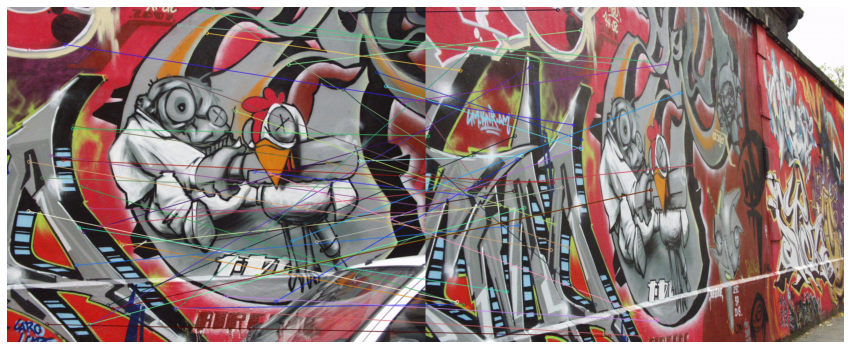

In [24]:
# Match sift features
img1 = cv.imread('graf/img1.ppm')  
img2 = cv.imread('graf/img5.ppm')

sift = cv.SIFT_create()
keypoint_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoint_2, descriptors_2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
#sorting to get the best matches
matches = sorted(matches, key = lambda x:x.distance)

fig, ax = plt.subplots(figsize = (15,15))
ax.axis('off')
matched_img = cv.drawMatches(img1, keypoint_1, img2, keypoint_2, matches[:50], img2, flags = 2)
plt.imshow(cv.cvtColor(matched_img,cv.COLOR_BGR2RGB))
plt.show()